In [ ]:
!pip install findspark
!pip install contractions
!pip install num2words
!pip install nltk
!pip install pandas
!pip install pyarrow
!pip install seaborn
!pip install matplotlib
!pip install wordcloud
!pip install plotly
!pip install dash


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip insta

In [ ]:
!wget -q http://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/default"
os.environ["SPARK_HOME"] = "spark-3.5.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/23 21:27:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/23 21:27:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Preprocessing

## Import Data

In [ ]:
df = spark.read.csv('data/tweets.csv', header=True, inferSchema=True)
df.printSchema()

root
 |-- Target: integer (nullable = true)
 |-- ID: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- User: string (nullable = true)
 |-- Text: string (nullable = true)



In [ ]:
df_orig = df

df_orig.show(5, truncate=False)

+------+----------+----------------------------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|Target|ID        |Date                        |flag    |User         |Text                                                                                                           |
+------+----------+----------------------------+--------+-------------+---------------------------------------------------------------------------------------------------------------+
|0     |1467810672|Mon Apr 06 22:19:49 PDT 2009|NO_QUERY|scotthamilton|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!|
|0     |1467810917|Mon Apr 06 22:19:53 PDT 2009|NO_QUERY|mattycus     |@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                      |
|0     |1467811184|Mon Apr 06 22:19:57 PDT 2009|NO_QUERY|ElleCTF      |my whole 

## Dataframe Preprocessing

In [ ]:
from pyspark.sql.functions import to_timestamp, weekday, hour, col, when
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df = df.drop('flag')

datetime_string = "EEE MMM dd HH:mm:ss z yyyy"
df = df.withColumn('Date', to_timestamp(df.Date, datetime_string))
df = df.withColumn('Day', weekday(df.Date))
df = df.withColumn('Hour', hour(df.Date))

df = df.withColumnRenamed('Target', 'Positive')
df = df.withColumn('Positive', when(col('Positive') == 4, 1).otherwise(0))

df.show(5)

+--------+----------+-------------------+-------------+--------------------+---+----+
|Positive|        ID|               Date|         User|                Text|Day|Hour|
+--------+----------+-------------------+-------------+--------------------+---+----+
|       0|1467810672|2009-04-07 00:19:49|scotthamilton|is upset that he ...|  1|   0|
|       0|1467810917|2009-04-07 00:19:53|     mattycus|@Kenichan I dived...|  1|   0|
|       0|1467811184|2009-04-07 00:19:57|      ElleCTF|my whole body fee...|  1|   0|
|       0|1467811193|2009-04-07 00:19:57|       Karoli|@nationwideclass ...|  1|   0|
|       0|1467811372|2009-04-07 00:20:00|     joy_wolf|@Kwesidei not the...|  1|   0|
+--------+----------+-------------------+-------------+--------------------+---+----+
only showing top 5 rows



In [ ]:
crime_keywords = ['murder', 'murderer', 'theft', 'assault', 'robbery', 'stole', 'steal', 'stealing', 'burglary', 'arrest', 'arson', 'drug', 'drugs', 'police', 'suspect', 'violence']

df = df.withColumn(
    'crime_related',
    when(col('Text').rlike("(?i)\\b(" + "|".join(crime_keywords) + ")\\b"), 1).otherwise(0)
)

df.groupBy('crime_related').count().show()

+-------------+-------+
|crime_related|  count|
+-------------+-------+
|            1|   2225|
|            0|1046350|
+-------------+-------+



In [ ]:
df_crime = df.filter(col('crime_related')==1)
df_crime.select('Text').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+
|Text                                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------------------+
| Body Of Missing Northern Calif. Girl Found: Police have found the remains of a missing Northern California girl .. http://tr.im/imji|
|augh, eff sarth  i stole some of MIL's nail polish, its pretty! =o                                                                   |
|so a murder? gotcha.  Cant believe it                                                                                                |
|Megan equals Murder.                                                                                                                 |
|@grahamcracker  If only you were working in the

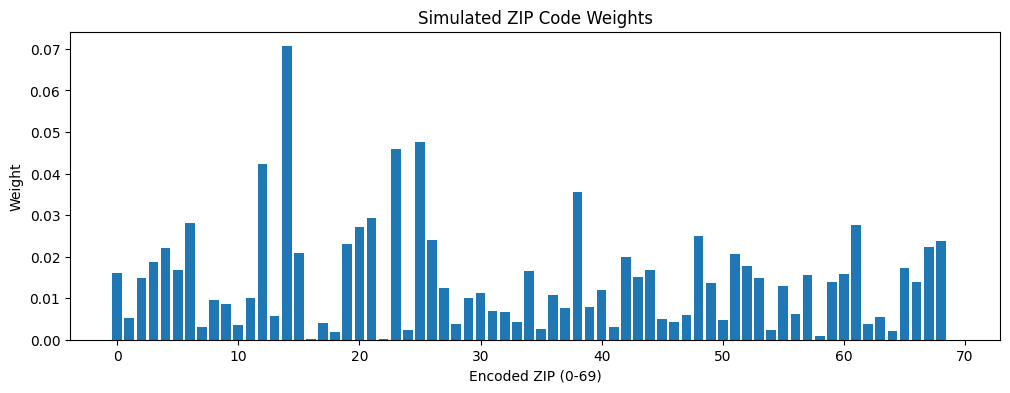

+--------+----------+-------------------+-------------+--------------------+---+----+-------------+---+
|Positive|        ID|               Date|         User|                Text|Day|Hour|crime_related|Zip|
+--------+----------+-------------------+-------------+--------------------+---+----+-------------+---+
|       0|1467810672|2009-04-07 00:19:49|scotthamilton|is upset that he ...|  1|   0|            0| 52|
|       0|1467810917|2009-04-07 00:19:53|     mattycus|@Kenichan I dived...|  1|   0|            0| 43|
|       0|1467811184|2009-04-07 00:19:57|      ElleCTF|my whole body fee...|  1|   0|            0| 19|
|       0|1467811193|2009-04-07 00:19:57|       Karoli|@nationwideclass ...|  1|   0|            0|  9|
|       0|1467811372|2009-04-07 00:20:00|     joy_wolf|@Kwesidei not the...|  1|   0|            0| 20|
+--------+----------+-------------------+-------------+--------------------+---+----+-------------+---+
only showing top 5 rows



In [ ]:
import numpy as np
from pyspark.sql.functions import rand, floor, udf
from pyspark.sql.types import IntegerType

zip_weights = np.random.dirichlet(np.ones(70), size=1)[0]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.bar(range(70), zip_weights)
plt.xlabel("Encoded ZIP (0-69)")
plt.ylabel("Weight")
plt.title("Simulated ZIP Code Weights")
plt.show()

def weighted_zip_sampler():
    choices = list(range(70))
    return lambda: int(np.random.choice(choices, p=zip_weights))

sample_zip_udf = udf(weighted_zip_sampler(), IntegerType())

# simulate zip code approximation from IP address
#df = df.withColumn("Zip", floor(rand() * 70).cast("int"))
df = df.withColumn("Zip", sample_zip_udf())

df.show(5)

In [ ]:
count_0 = df.filter(df.crime_related == 0).count()
count_1 = df.filter(df.crime_related == 1).count()

class_ratio = count_1 / count_0

df_0 = df.filter(df.crime_related == 0).sample(withReplacement=False, fraction=class_ratio, seed=42)
df_1 = df.filter(df.crime_related == 1)

df_balanced = df_0.union(df_1)

# shuffle rows
df_balanced = df_balanced.orderBy(rand())

df_balanced.show()

[Stage 15:============================>                          (21 + 19) / 40]

+--------+----------+-------------------+--------------+--------------------+---+----+-------------+---+
|Positive|        ID|               Date|          User|                Text|Day|Hour|crime_related|Zip|
+--------+----------+-------------------+--------------+--------------------+---+----+-------------+---+
|       0|1956298160|2009-05-28 23:34:58|    jeslynfong|3 hours of sleep ...|  3|  23|            0| 12|
|       0|1968397635|2009-05-29 23:21:11|       exor674|Ugg, I still smel...|  4|  23|            0| 59|
|       0|1977679642|2009-05-30 23:28:16|     minorityx|@kimhade come wit...|  5|  23|            0| 44|
|       0|1695657008|2009-05-04 08:39:15|     aprilmann|@n_nakao Yes he d...|  0|   8|            1| 62|
|       0|1969366496|2009-05-30 01:48:44|        shauom|If I hit mi broth...|  5|   1|            1| 31|
|       0|2300967525|2009-06-23 16:49:37|bornroccaforte|Back home  wish i...|  1|  16|            1| 17|
|       0|1827549589|2009-05-17 12:56:57| RingLeader898

## Text Preprocessing

In [ ]:
import re
import contractions
import nltk
import pyarrow
import html

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from num2words import num2words
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('universal_tagset')

[nltk_data] Downloading package wordnet to /home/antlers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antlers/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/antlers/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
zip_dict = {
    0: '64102',
    1: '64105',
    2: '64106',
    3: '64108',
    4: '64109',
    5: '64101',
    6: '64110',
    7: '64111',
    8: '64112',
    9: '64113',
    10: '64114',
    11: '64116',
    12: '64117',
    13: '64119',
    14: '64120',
    15: '64125',
    16: '64126',
    17: '64127',
    18: '64128',
    19: '64129',
    20: '64134',
    21: '64136',
    22: '64137',
    23: '64138',
    24: '64118',
    25: '64121',
    26: '64123',
    27: '64124',
    28: '64130',
    29: '64131',
    30: '64132',
    31: '64133',
    32: '64139',
    33: '64141',
    34: '64144',
    35: '64148',
    36: '64149',
    37: '64152',
    38: '64145',
    39: '64146',
    40: '64147',
    41: '64151',
    42: '64153',
    43: '64154',
    44: '64155',
    45: '64156',
    46: '64157',
    47: '64163',
    48: '64164',
    49: '64165',
    50: '64170',
    51: '64171',
    52: '64187',
    53: '64188',
    54: '64197',
    55: '64198',
    56: '64199',
    57: '64158',
    58: '64161',
    59: '64166',
    60: '64167',
    61: '64168',
    62: '64179',
    63: '64180',
    64: '64184',
    65: '64190',
    66: '64191',
    67: '64195',
    68: '64196',
    69: '64999'
}

In [ ]:
acronyms = {
    "mr.": "mister", "mrs.": "misses", "dr.": "doctor", "st.": "street",
    "u.s.": "united states", "e.g.": "for example", "i.e.": "that is",
    "vs.": "versus", "w/": "with", "w/o": "without", "n/a": "not applicable",
    "thx": "thanks", "u": "you", "wut": "what", "wtf": "what the fuck",
    "idk": "i do not know", "luv": "love", "irl": "in real life"
}
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

In [ ]:
### Preprocessing Functions
def expand_contractions_and_acronyms(text):
    text = contractions.fix(text)
    pattern = re.compile(r'\b(' + '|'.join(acronyms.keys()) + r')\b', re.IGNORECASE)
    text = pattern.sub(lambda m: acronyms.get(m.group(0).lower(), m.group(0)), text)
    return text

def handle_web_elements(text):
    text = re.sub(r'@[\w_]+', '<user>', text)
    text = re.sub(r'#[\w_]+', '<hashtag>', text)
    text = re.sub(r'\$', ' dollar ', text)
    text = re.sub(r'€', ' euro ', text)
    text = re.sub(r'http\S+', 'URL', text)
    return text

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def remove_stopwords(tokens):
    return [token for token in tokens if token not in stop_words]

def lemmatize_with_pos(tokens):
    pos_tags = pos_tag(tokens)
    lemmas = []
    for token, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(token, pos=wn_tag) if wn_tag else lemmatizer.lemmatize(token)
        lemmas.append(lemma)
    return lemmas

def preprocess_text(text, use_spelling_correction=False, convert_numbers=False):
    text = text.lower()
    text = html.unescape(text)
    text = expand_contractions_and_acronyms(text)
    text = handle_web_elements(text)
    text = re.sub(r'[+-]?(\d*\.)?\d+', lambda m: num2words(m.group()), text)
    text = remove_punctuation(text)
    tokens = word_tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_with_pos(tokens)
    return ' '.join(tokens)

In [ ]:
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import StringType

@pandas_udf(StringType())
def preprocess_text_udf(text_series):
    return text_series.apply(preprocess_text)

df_balanced = df_balanced.withColumn("Text_Preprocessed", preprocess_text_udf(df_balanced["Text"]))
df_balanced.show(5)

df = df.withColumn("Text_Preprocessed", preprocess_text_udf(df_balanced["Text"]))

[Stage 19:>                                                         (0 + 1) / 1]

+--------+----------+-------------------+----------+--------------------+---+----+-------------+---+--------------------+
|Positive|        ID|               Date|      User|                Text|Day|Hour|crime_related|Zip|   Text_Preprocessed|
+--------+----------+-------------------+----------+--------------------+---+----+-------------+---+--------------------+
|       0|1956298160|2009-05-28 23:34:58|jeslynfong|3 hours of sleep ...|  3|  23|            0| 15|three hour sleep ...|
|       0|1968397635|2009-05-29 23:21:11|   exor674|Ugg, I still smel...|  4|  23|            0|  6|ugg still smell c...|
|       0|1977679642|2009-05-30 23:28:16| minorityx|@kimhade come wit...|  5|  23|            0| 38|           user come|
|       0|1695657008|2009-05-04 08:39:15| aprilmann|@n_nakao Yes he d...|  0|   8|            1| 66|user yes alcoholi...|
|       0|1969366496|2009-05-30 01:48:44|    shauom|If I hit mi broth...|  5|   1|            1| 49|hit mi brother si...|
+--------+----------+---

# Modeling

## Training Split

In [ ]:
# splitting dataset into train and test set
train, test = df_balanced.randomSplit([0.7, 0.3], seed=42)

## Text Vectorization

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="Text_Preprocessed", outputCol="Tokens")
stop_filter = StopWordsRemover(inputCol="Tokens", outputCol="Filtered")
vectorizer = HashingTF(inputCol="Filtered", outputCol="Vectors", numFeatures=10000)

pipeline = Pipeline(stages=[tokenizer, stop_filter, vectorizer])
pipeline_model = pipeline.fit(train)

train_transformed = pipeline_model.transform(train)
test_transformed = pipeline_model.transform(test)

full_transformed = train_transformed.union(test_transformed)

original_transformed = pipeline_model.transform(df)

In [ ]:
feature_cols = [col for col in df_balanced.columns if col != 'crime_related']

X_train = train.select(*feature_cols)
y_train = train.select('crime_related')

X_test = test.select(*feature_cols)
y_test = test.select('crime_related')

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Logistic Regression
lr = LogisticRegression(featuresCol="Vectors", labelCol="crime_related")

# Train the model
lr_model = lr.fit(train_transformed)

# Make predictions
predictions = lr_model.transform(test_transformed)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="crime_related")
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy:.4f}")

[Stage 99:>                                                         (0 + 1) / 1]

Model Accuracy: 0.9392


In [ ]:
from pyspark.sql.functions import count
from pyspark.sql.functions import sum as spark_sum

predictions = lr_model.transform(original_transformed)

predictions = predictions.withColumn("crime_predicted", when(col("prediction") == 1.0, 1).otherwise(0).cast("int"))

# Group by ZIP and aggregate
zip_crime_stats = predictions.groupBy("Zip").agg(
    count("*").alias("total_posts"),
    spark_sum("crime_predicted").alias("predicted_crime_posts")
)

# Add a crime ratio column
zip_crime_stats = zip_crime_stats.withColumn(
    "crime_ratio", col("predicted_crime_posts") / col("total_posts")
)

top_zip_pd = zip_crime_stats.toPandas()

In [ ]:
num_zips = 10

In [ ]:
top_zip_pd['Zip'] = top_zip_pd['Zip'].map(zip_dict)
top_zips = top_zip_pd.sort_values("crime_ratio", ascending=False).head(num_zips)
bottom_zips = top_zip_pd.sort_values("crime_ratio", ascending=True).head(num_zips)

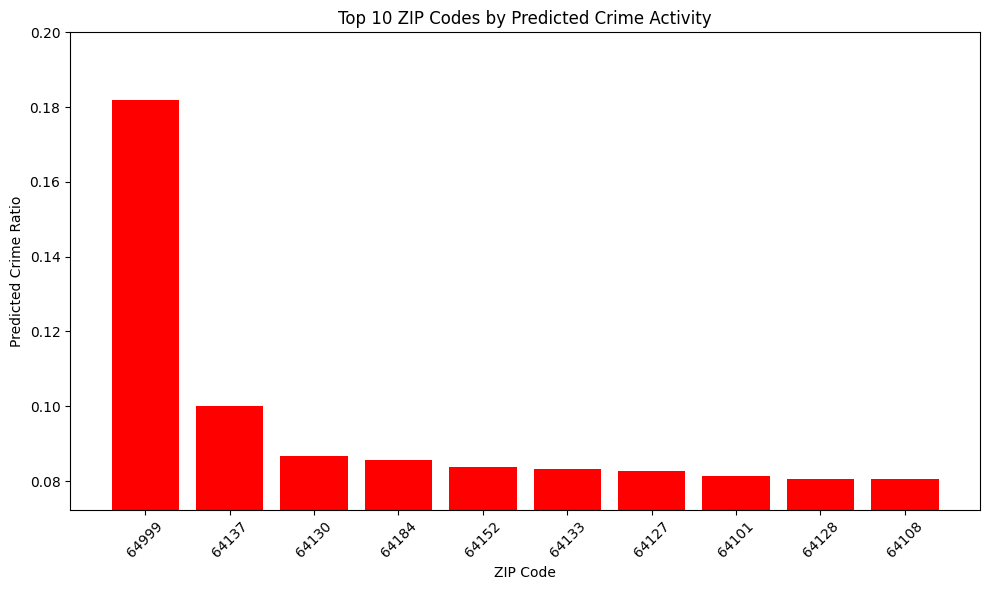

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(top_zips["Zip"], top_zips["crime_ratio"], color="red")
plt.xlabel("ZIP Code")
plt.ylabel("Predicted Crime Ratio")
plt.title(f"Top {num_zips} ZIP Codes by Predicted Crime Activity")
plt.xticks(rotation=45)
plt.ylim([top_zips["crime_ratio"].min() * 0.9, top_zips["crime_ratio"].max() * 1.1])
plt.tight_layout()
plt.show()

## Statistical Visualizations

### Time/Day Heatmap

In [ ]:
time_counts = df_balanced.filter(df_balanced.crime_related == 1) \
                .groupBy("day", "hour") \
                .count()

time_pd = time_counts.toPandas().pivot(index='day', columns='hour', values='count').fillna(0)

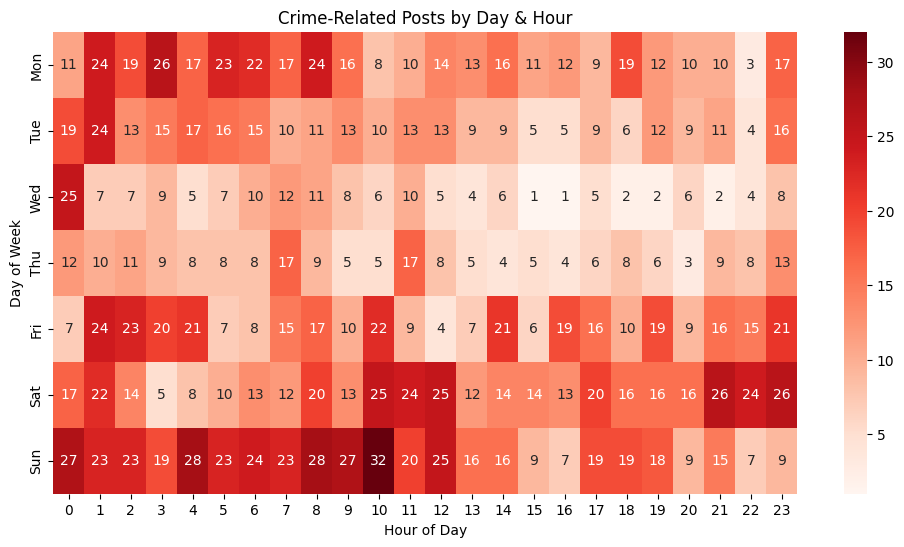

In [ ]:
day_map = {
    0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
}

time_pd.index = time_pd.index.map(day_map)

plt.figure(figsize=(12,6))
sns.heatmap(time_pd, cmap='Reds', annot=True, fmt='.0f')
plt.title("Crime-Related Posts by Day & Hour")
plt.ylabel("Day of Week")
plt.xlabel("Hour of Day")
plt.show()

### Crime-Related Wordcloud

In [ ]:
from wordcloud import WordCloud

# Collect crime-related text
crime_text = df_balanced.filter(df_balanced.crime_related == 1).select("Text_Preprocessed").rdd.flatMap(lambda x: x).collect()
text_blob = " ".join(crime_text)

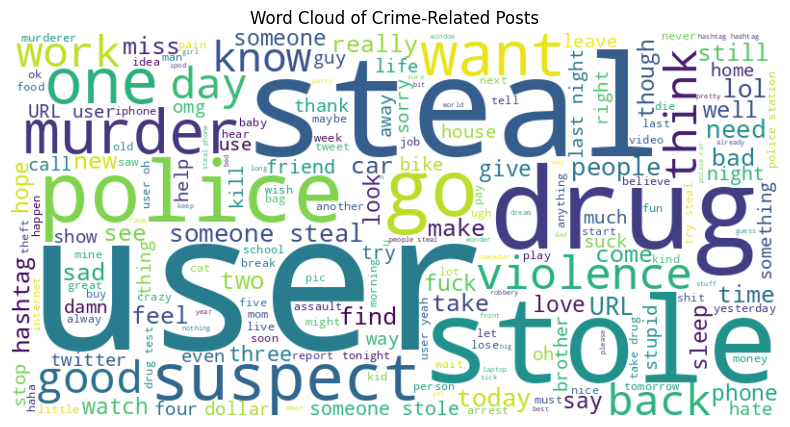

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_blob)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Crime-Related Posts")
plt.show()

In [ ]:
from pyspark.sql.functions import to_date

# Ensure date is formatted
df_balanced = df_balanced.withColumn("Date_Only", to_date("Date"))

daily_counts = df_balanced.filter(df_balanced.crime_related == 1) \
                 .groupBy("Date_Only") \
                 .count() \
                 .orderBy("Date_Only")

daily_pd = daily_counts.toPandas()

### Trends in Crime-Related Posts

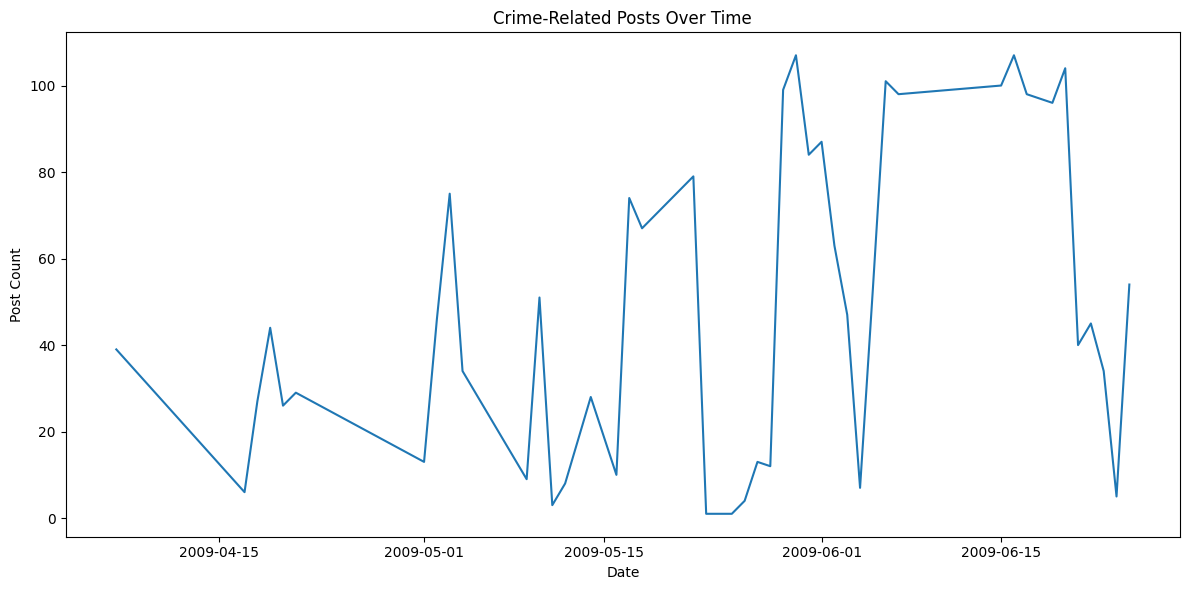

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=daily_pd, x='Date_Only', y='count')
plt.title("Crime-Related Posts Over Time")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.tight_layout()
plt.show()

## Anomaly Detection

In [ ]:
# Group by date and zipcode
zip_daily_counts = df_balanced.filter(df_balanced.crime_related == 1) \
                     .groupBy("Date_Only", "Zip") \
                     .count() \
                     .orderBy("Date_Only", "Zip")

# Convert to pandas
zip_daily_pd = zip_daily_counts.toPandas()
zip_daily_pd.columns = ['Date', 'Zipcode', 'Count']
zip_daily_pd['Zipcode'] = zip_daily_pd['Zipcode'].map(zip_dict)

In [ ]:
# Group by ZIP code
def compute_anomalies_by_zip(group):
    mean = group['Count'].mean()
    std = group['Count'].std()
    group['z_score'] = (group['Count'] - mean) / std
    group['anomaly'] = group['z_score'].apply(lambda x: 1 if x > 2 else 0)
    return group

zip_anomalies = zip_daily_pd.groupby('Zipcode').apply(compute_anomalies_by_zip).reset_index(drop=True)

/tmp/ipykernel_426141/3281085296.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  zip_anomalies = zip_daily_pd.groupby('Zipcode').apply(compute_anomalies_by_zip).reset_index(drop=True)


In [ ]:
import dash
from dash import dcc, html
import plotly.express as px

df = zip_anomalies.copy()

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Crime Post Anomalies by ZIP Code"),
    dcc.Dropdown(
        id='zip-dropdown',
        options=[{'label': z, 'value': z} for z in sorted(df['Zipcode'].unique())],
        value=sorted(df['Zipcode'].unique())[0]
    ),
    dcc.Graph(id='anomaly-graph')
])

@app.callback(
    dash.dependencies.Output('anomaly-graph', 'figure'),
    [dash.dependencies.Input('zip-dropdown', 'value')]
)
def update_graph(selected_zip):
    filtered = df[df['Zipcode'] == selected_zip]
    fig = px.line(filtered, x='Date', y='Count', title=f'ZIP {selected_zip}')
    anomalies = filtered[filtered['anomaly'] == 1]
    fig.add_scatter(x=anomalies['Date'], y=anomalies['Count'],
                    mode='markers', marker=dict(color='red', size=8), name='Anomaly')
    return fig

if __name__ == '__main__':
    app.run(debug=True)